<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task" data-toc-modified-id="Task-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Calculate-Term-Frequencies" data-toc-modified-id="Calculate-Term-Frequencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate Term Frequencies</a></span></li><li><span><a href="#Compute-topics-using-Kmeans-and-LDA" data-toc-modified-id="Compute-topics-using-Kmeans-and-LDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compute topics using Kmeans and LDA</a></span></li><li><span><a href="#Show-cluster-top-15-words" data-toc-modified-id="Show-cluster-top-15-words-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Show cluster top 15 words</a></span></li><li><span><a href="#Prepare-before-ploting" data-toc-modified-id="Prepare-before-ploting-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prepare before ploting</a></span></li><li><span><a href="#Plot-Data" data-toc-modified-id="Plot-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot Data</a></span></li><li><span><a href="#Calculate-model-accuracies" data-toc-modified-id="Calculate-model-accuracies-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Calculate model accuracies</a></span></li><li><span><a href="#Training-the-model-of-choice-and-tuning-hyperparameters" data-toc-modified-id="Training-the-model-of-choice-and-tuning-hyperparameters-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Training the model of choice and tuning hyperparameters</a></span></li><li><span><a href="#Testing-on-validation-set" data-toc-modified-id="Testing-on-validation-set-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Testing on validation set</a></span></li><li><span><a href="#Ploting-results" data-toc-modified-id="Ploting-results-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Ploting results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

### Task

1. Прочитать с помощью Pandas две таблицы
 - commits.csv
 - issues.csv 
2. Объединить таблицы по полю Key.
3. Выбрать столбцы:
 - 'author_name' – имя автора коммита;
 - 'author_email' – почта автора коммита;
 - 'committer_name' – имя исполнителя;
 - 'committer_email' – почта исполнителя;
 - 'time' – время коммита;
 - 'time_offset' – отклонение во времени;
 - 'message_encoding' – текст коммита. 
как независимые переменные, и столбец
 - ‘severity’ – степень ошибки как зависимую переменную для предсказания.
4. Провести статистический анализ данных (exploratory data analysis), используя произвольные тип визуализации, в частности, сколько коммитов в день делает пользователь и т.д.
5. Заполнить пропущенные значения в столбцах.
6. Превратить категорийные текстовые переменные в числовые.
7. Превратить некатегорийные текстовые переменные в векторы любым оптимальным способом. В случае необходимости, Вы можете дополнять dataset дополнительными переменными.
8. Разделить dataset на train и test части.
9. Построить модель, которая будет предсказывать переменную severity для тестового dataset на основании данных в train dataset.
10. Протестировать несколько моделей и выбрать из них лучшую. А именно:
- использовать Sklearn библиотеку (модели: Random Forest, Decision trees, Naive Bayes, SVM, etc.)
- использование нейронных сетей будет плюсом. Можна взять Keras.io и натренировать нейронную сеть (выбрать Fully Connected Layer или другую архитектуру).
11. Оптимизировать модели с использованием cross validation, grid search, etc.
12. Оценить эффективность моделей на test datataset с использованием нескольких метрик на Ваше усмотрение и указать наиболее эффективную модель.
13. Визуализировать confusion matrix для сравнения результатов.
14. Кратко описать полученные результаты и их сравнение на английском языке. Выразить свое мнение, почему некоторые модели работают лучше или хуже.

### Load

This notebook is a 2 part hands-on demonstration of working with commiters data for text analytics. The first part uses LDA and Kmeans algorithms to automatically group text based on commit log [example](http://mail-archives.apache.org/mod_mbox/spark-commits/201503.mbox/%3C504db81bc3444ac2833dc23e50ee84c0@git.apache.org%3E). 

The second part covers predicting commits severity scores using most popular models based on contents of the message. The end shows how to predict the severity probability.

Commits messages can probably span from 1 to 10 severity level. I don't know why, but as we saw in EDA, in our file we got only 0, 1, 3, 5, 10. I use approach, that can help to show likelihood of each of them. Unfortunately, I don't have information about them, but if I could, it will be look like:   

- Low: 1-3 levels
- Moderate: 4-6 levels
- Critical: 7-10 levels

In [1]:
import pandas as pd, numpy as np

In [2]:
!ls data/

commits.zip  issues.zip  test.csv  train.csv


In [3]:
train = pd.read_csv('data/train.csv', index_col='time')
test = pd.read_csv('data/test.csv', index_col='time')

We won't touch X_valid, y_valid until the end

In [4]:
X_train, y_train, X_valid, y_valid = train[[col for col in train.columns if col!='severity']], train['severity'],\
                                     test[[col for col in train.columns if col!='severity']], test['severity']

### Calculate Term Frequencies

We calculate both the actual term frequency as well as the tfidf weighted term frequency. For both algorithms, we limit to words occuring in at most 80% of text and in at least 20 commits. While the term-frequency matrix is just a word count, the IDF calculation adjusts for not significant words that occur in messages.

We perform two tokenizing operations. In addition we can ignore special symbols & numbers and use the NLTK Snowball stemmer to get the root of a word as best as possible, also remove stopwords, but it hasn't affected on the result, so I had stopped using it. Firstly because these words can give some additional information, like commiter, link etc, secondly it doesn't affect on scores.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import re

import scipy.sparse as sps

In [6]:
def pre(s):
    return re.sub(r'[^\w]', ' ', s)

def tokenize(text):
    tokenizer = RegexpTokenizer("[a-z']+")
    stemmer = SnowballStemmer("english")
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

In [7]:
def Vect(df, use_idf=True, min_df=1, max_df=1.0, ngram_range = (4,10)):
    '''
    Tfidf or tf vectorizing
    
    us_idf: bool([True, False]), use tfidf or not;
    min_df: float()
    max_df: float()
    ngram_range: tuple(None, None)
    '''
    if use_idf == True:
        tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), preprocessor=None,
                                ngram_range=ngram_range, strip_accents='ascii', analyzer='word',
                                min_df = min_df, max_df=max_df, tokenizer=None)
    
        message_encoding = tfidf.fit_transform(df['message_encoding'])
        
        return message_encoding, tfidf
    
    else:
        tf = CountVectorizer(stop_words=stopwords.words('english'), preprocessor=None,
                             ngram_range=ngram_range, strip_accents='ascii', analyzer='word',
                             min_df = min_df, max_df=max_df, tokenizer=None)

        message_encoding = tf.fit_transform(df['message_encoding'])
        
        return message_encoding, tf

In [8]:
X_train_idf, train_idf_m = Vect(X_train, max_df=0.80, min_df=20)
X_train_tf, train_tf_m = Vect(X_train, use_idf=False, max_df=0.80, min_df=20)

### Compute topics using Kmeans and LDA

We are using two approaches to extract topics from our messages set.

Approach 1 (Kmeans): Using our TFIDF matrix, we cluster them into N clusters based on their TFIDF similarity. Within each cluster, we count the top occuring terms.

Approach 2 (LDA): Using our TF matrix, we attempt to extact N topics from our collection.

Kmeans forces each text to belong to only one cluster while LDA allows a commit to have many topics associated with it. I pulled 10 topics out of my head as a nice starting number, that seemed good.

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler

In [10]:
n_topics = 10

def get_lda(data, topics):
    lda = LatentDirichletAllocation(n_topics=topics, n_jobs=-1, learning_method='online').fit(data)
    data = lda.transform(data)
    return lda, data

def get_kmeans(data, k, scale=True):
    if scale:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    
    kmean = KMeans(n_clusters=k).fit(data)
    data = kmean.predict(data)
    return kmean, data        

In [11]:
lda_m, lda_d = get_lda(X_train_tf, n_topics)
kmean_m, kmean_d = get_kmeans(X_train_idf, n_topics, scale=False)

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


### Show cluster top 15 words
First extract the top 15 stemmed words per topic in our LDA model. As a second step, we do something similar for our kmeans. Here we just count the top 15 most frequent stemmed words per cluster. Both show similar sets of results.

In [12]:
def show_topics(model, feature_names, n_words):
    '''
    http://scikit-learn.org/0.18/auto_examples/applications/topics_extraction_with_nmf_lda.html
    '''
    for topic_idx, topic in enumerate(model.components_):
        print(("Topic of commit #%d:" % topic_idx))
        print((", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]])))
    print()
    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print(("Cluster #%d:" % col))
        print((", ".join([feature_names[i]
                for i in top_n])))
    print()

In [13]:
show_topics(lda_m, train_tf_m.get_feature_names(), 15)

Topic of commit #0:
changes proposed pull request, proposed pull request pr, changes proposed pull request pr, liu davies databricks com closes, author davies liu davies databricks com closes, davies liu davies databricks com closes, davies databricks com closes, author cheng lian lian, davies liu davies databricks, liu davies databricks com, author davies liu davies databricks com, davies liu davies databricks com, author davies liu davies databricks, lian lian databricks com, cheng lian lian databricks
Topic of commit #1:
github com apache spark, https github com apache, https github com apache spark, github com apache spark pull, https github com apache spark pull, com apache spark pull, branch master github com, merge branch master github com, merge branch master github, branch master github com apache, branch master github com apache spark, master github com apache, merge branch master github com apache, master github com apache spark, merge branch master github com apache spark
T

In [14]:
print("Top 15 words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, X_train_idf, train_tf_m.get_feature_names(), 15)

Top 15 words per cluster in Kmeans model

Cluster #0:
author sean owen sowen cloudera com closes, owen sowen cloudera com closes, sean owen sowen cloudera com closes, sowen cloudera com closes, author sean owen sowen, author sean owen sowen cloudera, author sean owen sowen cloudera com, owen sowen cloudera com, sean owen sowen cloudera, sean owen sowen cloudera com, https github com apache, com apache spark pull, github com apache spark pull, https github com apache spark pull, https github com apache spark
Cluster #1:
changes proposed pull request, github com apache spark, master squashes following commits, author davies liu davies, https github com apache, us ibm com closes, https github com apache spark, author davies liu davies databricks, author davies liu davies databricks com, davies liu davies databricks, davies liu davies databricks com, liu davies databricks com, author davies liu davies databricks com closes, davies databricks com closes, davies liu davies databricks com clo

### Prepare before ploting

Our TF/TFIDF matricies are thousands of attributes wide which makes it a challenge to graphically represent documents as we are limited to 3 dimensions. We could perform a heirarchical clustering, but the number of documents make this approach very slow. Instead, we perform a SVD to reduce the dimensionality of the matrix to something more manageable.

We then use t-SNE to attempt to visually cluster and represent our data as best as possible in 2 dimensions. 

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [16]:
def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(X_train_idf, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

### Plot Data

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

In [18]:
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, 
               fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

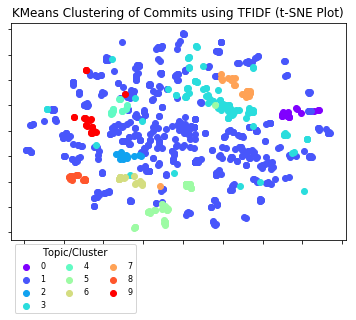

In [19]:
%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Commits using TFIDF (t-SNE Plot)')

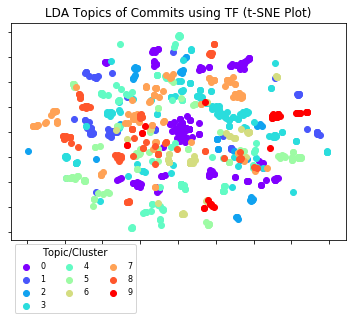

In [20]:
%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Commits using TF (t-SNE Plot)')

### Calculate model accuracies
I got a good intel processor, so we can try a lot of models. Also try a final approach that does a combined "vote" of all three models.

The accuracy % are printed below for each model.

In [21]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import datetime
from tqdm import tqdm_notebook

In [22]:
def calculate_cv(X, y):
    cv = TimeSeriesSplit(n_splits=6)
    results = {
        'lr': [],
        'svm': [],
        'dtc': [],
        'nb': [],
        'xgb': [],
        'adb': [],
        'etr': [],
        'kn': [],
        'rf': [],
        'bag': [],
        'sgd': [],
        'combined': []
    }
    
    lm = LogisticRegression()
    svm = LinearSVC()
    dtc = DecisionTreeClassifier()
    nb = MultinomialNB()
    xgb = XGBClassifier()
    adb = AdaBoostClassifier()
    etr = ExtraTreesClassifier()
    kn = KNeighborsClassifier()
    rf = RandomForestClassifier()
    bag = BaggingClassifier()
    sgd = SGDClassifier()
    vc = VotingClassifier([('lm', lm), ('dtc', dtc), ('nb', nb), 
                           ('xgb', xgb), ('adb', adb), ('etr', etr),
                           ('kn', kn), ('rf', rf), ('bag', bag),
                           ('sgd', sgd), ('svm', svm)])
    
    for c in tqdm_notebook([0,1,2,3,4]):
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['dtc'].append((cross_val_score(dtc, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['xgb'].append((cross_val_score(xgb, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['adb'].append((cross_val_score(adb, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['etr'].append((cross_val_score(etr, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['kn'].append((cross_val_score(kn, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['rf'].append((cross_val_score(rf, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['bag'].append((cross_val_score(bag, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['sgd'].append((cross_val_score(sgd, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=cv, scoring='accuracy', n_jobs=-1).mean(), c))
    
    print("Model accuracy predictions\n")
    for m,s in list(results.items()):
        for ss in s:
            print(("{M} model ({R} severity): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0])))
            print()

In [23]:
train['kmean_d'] = kmean_d

In [24]:
X_train_idf = sps.hstack((X_train_idf, train[['author_name', 'author_email', 'committer_name', 
                                              'committer_email', 'tm_year', 'tm_mon', 'tm_mday', 
                                              'tm_hour', 'tm_wday', 'tm_yday', 'first_w', 'kmean_d']]))

X_train_tf = sps.hstack((X_train_tf, train[['author_name', 'author_email', 'committer_name', 
                                              'committer_email', 'tm_year', 'tm_mon', 'tm_mday', 
                                              'tm_hour', 'tm_wday', 'tm_yday', 'first_w']], lda_d))

In [25]:
calculate_cv(X_train_idf, y_train)

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "a

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anacon

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "a


Model accuracy predictions

LR model (0 severity): 94.9%

LR model (1 severity): 76.8%

LR model (2 severity): 57.4%

LR model (3 severity): 90.6%

LR model (4 severity): 91.7%

SVM model (0 severity): 94.9%

SVM model (1 severity): 58.9%

SVM model (2 severity): 50.1%

SVM model (3 severity): 76.6%

SVM model (4 severity): 69.4%

DTC model (0 severity): 89.8%

DTC model (1 severity): 65.2%

DTC model (2 severity): 53.6%

DTC model (3 severity): 83.6%

DTC model (4 severity): 83.0%

NB model (0 severity): 77.9%

NB model (1 severity): 48.2%

NB model (2 severity): 53.6%

NB model (3 severity): 58.0%

NB model (4 severity): 69.7%

XGB model (0 severity): 94.8%

XGB model (1 severity): 76.5%

XGB model (2 severity): 59.1%

XGB model (3 severity): 90.4%

XGB model (4 severity): 91.4%

ADB model (0 severity): 93.0%

ADB model (1 severity): 74.6%

ADB model (2 severity): 58.5%

ADB model (3 severity): 90.1%

ADB model (4 severity): 90.6%

ETR model (0 severity): 94.0%

ETR model (1 severit

In [26]:
calculate_cv(X_train_tf, y_train)

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anacon

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "a

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "a

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array


Model accuracy predictions

LR model (0 severity): 94.5%

LR model (1 severity): 75.2%

LR model (2 severity): 57.8%

LR model (3 severity): 90.4%

LR model (4 severity): 91.1%

SVM model (0 severity): 94.9%

SVM model (1 severity): 58.9%

SVM model (2 severity): 50.0%

SVM model (3 severity): 76.6%

SVM model (4 severity): 92.0%

DTC model (0 severity): 90.2%

DTC model (1 severity): 66.7%

DTC model (2 severity): 52.8%

DTC model (3 severity): 84.2%

DTC model (4 severity): 85.3%

NB model (0 severity): 68.8%

NB model (1 severity): 47.7%

NB model (2 severity): 54.2%

NB model (3 severity): 58.8%

NB model (4 severity): 68.3%

XGB model (0 severity): 94.7%

XGB model (1 severity): 76.7%

XGB model (2 severity): 58.4%

XGB model (3 severity): 90.6%

XGB model (4 severity): 91.5%

ADB model (0 severity): 93.6%

ADB model (1 severity): 74.2%

ADB model (2 severity): 56.6%

ADB model (3 severity): 90.2%

ADB model (4 severity): 90.7%

ETR model (0 severity): 94.1%

ETR model (1 severit

### Training the model of choice and tuning hyperparameters

XGBoost with tf and additional features shows us the best score, so we will try to improve it with tuning. 

Always wanted to try hyperopt, instead of GridSearchCV or RandomSearchCV, for more clever way to tuning.
Unfortunately, there are a few versions of them, aren't good enough. So, I peaked the best solution, with default parameters.

Et tu, Brutforce!

In [27]:
from hyperopt import hp, fmin, tpe

In [28]:
def tuning(X, y, evals):

    params = []
    
    def f(param):
        trainX, trainY = X.todok(), y
        xgb = XGBClassifier(**param, n_jobs=1)
        cv = TimeSeriesSplit(n_splits=6)
        param["score"] = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
        params.append(param)
        return param["score"]
    
    param_space = {
        'silent': 1,
        'objective': 'binary:logistic',
        'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 150, dtype=int)),
        'max_depth': hp.choice('max_depth', np.arange(2, 13, 1, dtype=int)),
        'learning_rate': hp.quniform("eta", 0.001, 1, 0.001),
        'subsample': hp.quniform('subsample', 0.1, 1.0, 0.01),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
        'gamma': hp.quniform('gamma', 0.1, 10.0, 0.1),
        'reg_alpha': hp.choice('reg_alpha', np.arange(0, 2, 0.05)),
        'reg_lambda': hp.choice('reg_lambda',np.arange(0, 2, 0.05)),
        'min_child_weight': hp.quniform('min_child_weight', 1.0, 10.0, 0.1)
        }

    fmin(f, param_space, algo=tpe.suggest, max_evals=evals)
    params = sorted(params, key=lambda param : param['score'])
    best = params[0]
    print("**best param")
    print(best)
    
    return best


In [29]:
def get_xgb(x, y, evals = 10):
    models = []
    for c in tqdm_notebook([0,1,2,3,4]):
        y_adj = np.array(y==c)
        params = tuning(x, y_adj, evals)
        xgb = XGBClassifier(**params)
        xgb_f = xgb.fit(x, y_adj)
        models.append(xgb_f)
    return models

xgb_m = get_xgb(X_train_tf, y_train)

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**best param
{'colsample_bytree': 0.36, 'gamma': 1.3, 'learning_rate': 0.777, 'max_depth': 3, 'min_child_weight': 5.7, 'n_estimators': 250, 'objective': 'binary:logistic', 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5, 'silent': 1, 'subsample': 0.18, 'score': 0.9280405405405405}


/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**best param
{'colsample_bytree': 0.81, 'gamma': 6.0, 'learning_rate': 0.508, 'max_depth': 8, 'min_child_weight': 7.7, 'n_estimators': 850, 'objective': 'binary:logistic', 'reg_alpha': 0.9, 'reg_lambda': 1.1500000000000001, 'silent': 1, 'subsample': 0.23, 'score': 0.6942567567567567}


/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**best param
{'colsample_bytree': 0.81, 'gamma': 3.0, 'learning_rate': 0.402, 'max_depth': 7, 'min_child_weight': 3.9000000000000004, 'n_estimators': 700, 'objective': 'binary:logistic', 'reg_alpha': 0.2, 'reg_lambda': 1.7000000000000002, 'silent': 1, 'subsample': 0.13, 'score': 0.5434684684684684}


/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**best param
{'colsample_bytree': 0.93, 'gamma': 6.1000000000000005, 'learning_rate': 0.905, 'max_depth': 10, 'min_child_weight': 9.5, 'n_estimators': 400, 'objective': 'binary:logistic', 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.15000000000000002, 'silent': 1, 'subsample': 0.16, 'score': 0.8425675675675676}


/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**best param
{'colsample_bytree': 0.47000000000000003, 'gamma': 5.9, 'learning_rate': 0.923, 'max_depth': 3, 'min_child_weight': 4.3, 'n_estimators': 250, 'objective': 'binary:logistic', 'reg_alpha': 1.5, 'reg_lambda': 1.8, 'silent': 1, 'subsample': 0.23, 'score': 0.8438063063063063}



In [30]:
xgb_m

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.36, gamma=1.3, learning_rate=0.777,
        max_delta_step=0, max_depth=3, min_child_weight=5.7, missing=None,
        n_estimators=250, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0,
        reg_alpha=0.30000000000000004, reg_lambda=0.5, scale_pos_weight=1,
        score=0.9280405405405405, seed=None, silent=1, subsample=0.18),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.81, gamma=6.0, learning_rate=0.508,
        max_delta_step=0, max_depth=8, min_child_weight=7.7, missing=None,
        n_estimators=850, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0.9,
        reg_lambda=1.1500000000000001, scale_pos_weight=1,
        score=0.6942567567567567, seed=None, silent=1, subsample=0.23),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsamp

hyperopt shows us not enough scores lets use default parameters

### Testing on validation set

I will use simple precision, recall and f1-score. Because we don't know our business's task, I would like to choose the F-measure as a good candidate for the formal metric of assessing the quality of the classifier. It reduces to one number of two other fundamental metrics:  precision and recall. Having such a mechanism of evaluation at our solution will make it much easy for us to decide whether changes in the algorithm.

[Paper about severity classification](https://www.ijcsmc.com/docs/papers/July2016/V5I7201673.pdf)

In [55]:
from sklearn.metrics import accuracy_score, classification_report

In [38]:
def get_xgb_final(x, y):
    models = []
    for c in tqdm_notebook([0,1,2,3,4]):
        y_adj = np.array(y==c)
        xgb = XGBClassifier()
        xgb_f = xgb.fit(x, y_adj)
        models.append(xgb_f)
    return models

xgb_m_f = get_xgb_final(X_train_tf, y_train)

In [39]:
X_valid_tf = train_tf_m.transform(X_valid['message_encoding'])

In [40]:
lda_m_valid, lda_d_valid = get_lda(X_valid_tf, n_topics)

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [41]:
X_valid_tf = sps.hstack((X_valid_tf, test[['author_name', 'author_email', 'committer_name', 
                                           'committer_email', 'tm_year', 'tm_mon', 'tm_mday', 
                                           'tm_hour', 'tm_wday', 'tm_yday', 'first_w']], 
                         lda_d_valid))

In [57]:
def predict(X, y, models):
    proba = pd.DataFrame()
    result = pd.DataFrame()
    
    scores = []
    diff_metrics = []
    for ind, model in enumerate(models):
        predict_proba = model.predict_proba(X)
        predict = model.predict(X)
        scores.append(accuracy_score(y==ind, predict))
        diff_metrics.append(classification_report(y==ind , predict))
        result['predict_of_class_%d' % ind] = predict
        proba['proba_of_class_%d' % ind] = [i[1] for i in predict_proba]
    
    y_pred = []
    for i in range(len(proba)):
        y_pred.append(int(np.argmax(proba.loc[i]).split('_')[3]))
    
    return y_pred, result, scores, diff_metrics, proba

In [61]:
y_pred, result, scores, diff_metrics, proba = predict(X_valid_tf, y_valid, xgb_m_f)

print ('Final scores for each level:', scores)
for i in range(len(diff_metrics)):
    print ('Metrics on level %d \n' % i, diff_metrics[i])

Final scores for each level: [0.93058568329718, 0.702819956616052, 0.6691973969631236, 0.9696312364425163, 0.9674620390455532]
Metrics on level 0 
              precision    recall  f1-score   support

      False       0.93      1.00      0.96       858
       True       0.00      0.00      0.00        64

avg / total       0.87      0.93      0.90       922

Metrics on level 1 
              precision    recall  f1-score   support

      False       0.72      0.93      0.81       644
       True       0.52      0.17      0.26       278

avg / total       0.66      0.70      0.65       922

Metrics on level 2 
              precision    recall  f1-score   support

      False       0.65      0.52      0.57       400
       True       0.68      0.79      0.73       522

avg / total       0.67      0.67      0.66       922

Metrics on level 3 
              precision    recall  f1-score   support

      False       0.97      1.00      0.98       894
       True       0.00      0.00     

/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but 

In [66]:
print(classification_report(y_pred, y_valid))

             precision    recall  f1-score   support

          0       0.02      0.50      0.03         2
          1       0.28      0.51      0.36       152
          2       0.93      0.63      0.76       768
          3       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         0

avg / total       0.82      0.61      0.69       922



/home/denis/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Ploting results

Confusion matrix here.

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(list(range(cm.shape[0])), list(range(cm.shape[1]))):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  1   1   0   0   0]
 [ 38  77  35   1   1]
 [ 25 200 487  27  29]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


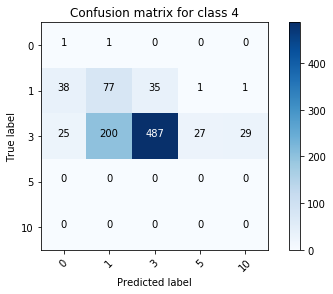

In [64]:
cnf_matrix = confusion_matrix(y_pred, y_valid)
np.set_printoptions(precision=2)
        
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 3, 5, 10],
                      title='Confusion matrix for class %d' %i)

In [69]:
def build_conf_matrix(y_valid, result):
    for i in [0,1,2,3,4]:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(result[result.columns[i]], y_valid==i)
        np.set_printoptions(precision=2)
        
        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=[False, True],
                              title='Confusion matrix for class %d' %i)

Confusion matrix, without normalization
[[858  64]
 [  0   0]]
Confusion matrix, without normalization
[[601 231]
 [ 43  47]]
Confusion matrix, without normalization
[[206 111]
 [194 411]]
Confusion matrix, without normalization
[[894  28]
 [  0   0]]
Confusion matrix, without normalization
[[892  30]
 [  0   0]]


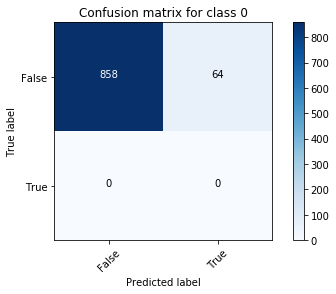

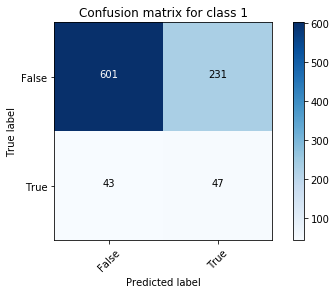

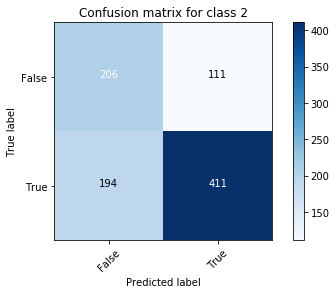

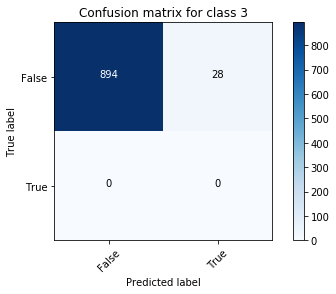

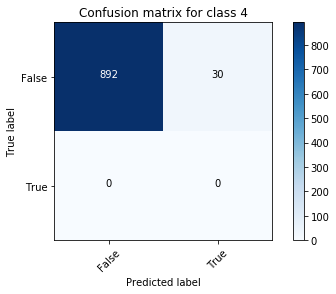

In [70]:
build_conf_matrix(y_valid, result)

### Conclusion

Our five models show quite an improvement over random guessing, but still opportunity to improve. There are lots of ways to tweak the prior steps to get a better result. 
- We didn't tweak any parameters in either the TF step or the modeling step
- Neg/Pos words have a lot of noise around, as we can see in example, more clever way of preprocessing can help.
- Maybe system text don't provide much insight and we are better off removing them
- Names or emails also can be deleted from message.
- Reclassification the task to rank problem, recommend project owners the less dangerous commits. 
- Word2vec, fasttext, hashing etc. approaches with good preprocessing.
- We can try to extract features with pymorphy, count of most famous words like commits etc.

<img src="https://sun1-2.userapi.com/c840735/v840735924/7a28f/iONO5E2guh0.jpg" />